# StreamSpot dataset

The StreamSpot dataset is composed of 600 provenance graphs derived from 5 benign and 1 attack scenarios. The benign scenarios involve normal behaviors of playing video games, checking emails in Google Mail, browsing cnn.com, downloading files, and watching YouTube videos. The attack scenario involves malicious behaviors of a drive-by download attack triggered by browsing a malicious URL which exploits a Flash vulnerability and further gains root access to the victim host. For each scenario, 100 tasks were executed automatically on a Linux machine. The Linux SystemTap logging system is used to record system call traces from the start of a task until its termination on the machine ( [source](https://www.hindawi.com/journals/scn/2021/9961342/))

Graph ID's correspond to scenarios as follows:

- YouTube (graph ID's 0 - 99)
- GMail (graph ID's 100 - 199)
- VGame (graph ID's 200 - 299)
- Drive-by-download attack (graph ID's 300 - 399)
- Download (graph ID's 400 - 499)
- CNN (graph ID's 500 - 599)

Tab-separated file with one edge on each line in the following format:

```
source-id	source-type	destination-id	destination-type	edge-type	graph-id
```


   1. Each node and edge type is mapped to a single character.
   2. Consecutive edges between the same pair of nodes corresponding to
      block-by-block file reads are collapsed into a single edge.
   4. The timestamp field is removed, raw edges are sorted by timestamp.

The data was dowloaded from [here](https://github.com/sbustreamspot/sbustreamspot-data/blob/master/all.tar.gz)
and saved as a parquet file in order to be able to filter on read to avoid reading the whole file


# This notebook contains 
- Basic Stats of the dataset
 - number of edges per graph type and graph id
 - number of distinct source nodes per graph type and graph id
 - number of distinct destination nodes per graph type and graph id
 
- Visualization of some of the graphs in the dataset

It is extremely important to start with the `descriptive` analytics to gain some understanding of the data we are working with.


##### Credits [StreamSpot Project](https://sbustreamspot.github.io/)   

# Basic Stats of the Data Set

In [2]:
from utils import *
%matplotlib inline

In [3]:
url = 'https://github.com/sbustreamspot/sbustreamspot-data/blob/master/all.tar.gz?raw=true'
url = './data/all.tar.gz'
chunks = pd.read_csv(url, sep='\t', chunksize=100000,  compression='gzip', header=None)

In [4]:
i = 0
df_source_destination_count = pd.DataFrame()
df_size = pd.DataFrame()
df_source_nodes = pd.DataFrame()
df_destination_nodes = pd.DataFrame()

for chunk in chunks:
    i += 1
    chunk.columns = ['source_id','source_type','destination_id','destination_type','edge_type','graph_id']
    chunk.dropna(inplace=True)
    chunk_gr = chunk.groupby(['graph_id'], as_index=False)[['source_id', 'destination_id']].nunique()
    df_source_destination_count = pd.concat([df_source_destination_count, chunk_gr], axis=0)

    chunk['graph_type'] = chunk.graph_id.map(lambda x: graph_type_map[x])
    chunk_gr = chunk.groupby(['graph_type','graph_id'], as_index=False).size()
    df_size = pd.concat([df_size, chunk_gr], axis=0)

    chunk_gr = chunk.groupby(['graph_type','source_type'], as_index=False)['source_id'].agg(set)
    df_source_nodes = pd.concat([df_source_nodes, chunk_gr], axis=0)

    chunk_gr = chunk.groupby(['graph_type','destination_type'], as_index=False)['destination_id'].agg(set)
    df_destination_nodes = pd.concat([df_destination_nodes, chunk_gr], axis=0)
    
    
df_source_destination_count = df_source_destination_count.groupby(['graph_id'],
                                                              as_index=False)[['source_id', 'destination_id']].agg('sum')    
df_source_destination_count.columns = ['graph_id','number_source_id','number_destination_id']
df_source_destination_count.graph_id  = df_source_destination_count.graph_id.astype('int')
df_source_destination_count['graph_type'] = df_source_destination_count.graph_id.map(lambda x: graph_type_map[x])

gr_source_nodes = df_source_nodes.groupby(['source_type'], 
                                          as_index=False)['source_id'].agg(lambda x:set.union(*list(x)))
gr_destination_nodes = df_destination_nodes.groupby(['destination_type'], 
                                          as_index=False)['destination_id'].agg(lambda x:set.union(*list(x)))

gr_source_nodes['NODE_TYPE'] = gr_source_nodes.source_type.map(lambda x: node_edge_map[x]) 
gr_destination_nodes['NODE_TYPE'] = gr_destination_nodes.destination_type.map(lambda x: node_edge_map[x]) 

gr_source_nodes['number_nodes'] = gr_source_nodes.source_id.map(lambda x: len(x))
gr_destination_nodes['number_nodes'] = gr_destination_nodes.destination_id.map(lambda x: len(x))

## Number of Edges per Graph Type

In [6]:
gr_size = df_size.groupby('graph_type', as_index=False).agg({'size':'sum'})
gr_size.style.set_caption("Total Number of Rows/Edges for Each Graph Type").set_table_styles(dfstyle)

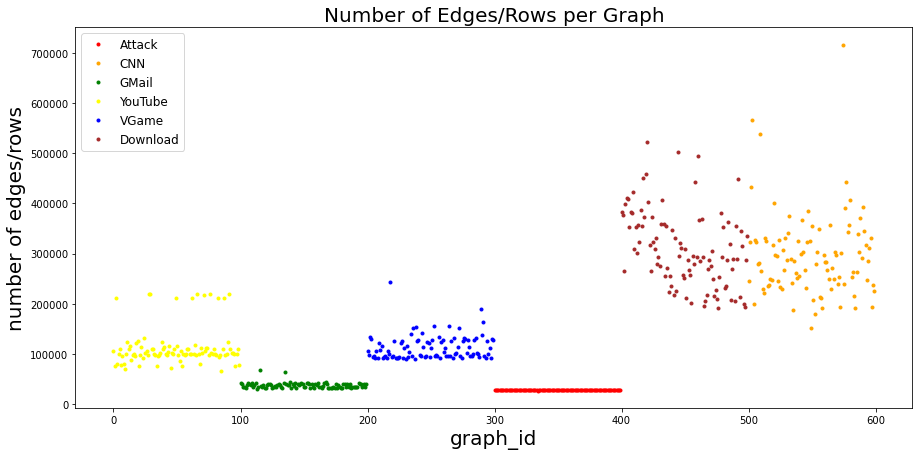

In [7]:
plt.figure(figsize=(15, 7))
gr_size = df_size.groupby(['graph_type', 'graph_id'], as_index=False)['size'].agg('sum')
graph_types = list(graph_type_color_map.keys())
colors = list(graph_type_color_map.values())
for idx in range(6):
    temp_df = gr_size[gr_size.graph_type == graph_types[idx]]
    plt.plot(temp_df.graph_id, temp_df['size'], '.', label =graph_types[idx], color=colors[idx])
    plt.xlabel('graph_id', fontsize=20)
    plt.ylabel('number of edges/rows',  fontsize=20)
plt.legend(fontsize=12, loc = 2)
plt.title('Number of Edges/Rows per Graph', fontsize=20)
plt.show()

## Number of Distinct Source and Destination Nodes

In [8]:
gr_source_dest = df_source_destination_count.groupby('graph_type', as_index=False)[['number_source_id','number_destination_id']].agg('sum')

gr_source_dest.style.set_caption("Total Number of Distinct Source and Destination Nodes for Each Graph Type").set_table_styles(dfstyle)

In [9]:
gr_source_nodes[['NODE_TYPE', 'number_nodes']].style.set_caption("Total Number of Distinct Source Nodes for Each Node Type").\
            set_table_styles(dfstyle)

In [10]:
gr_destination_nodes[['NODE_TYPE', 'number_nodes']].style.set_caption("Total Number of Distinct Destination Nodes for Each Node Type").\
            set_table_styles(dfstyle)

## Plot Number of Nodes for each Graph ID

There are 600 graph ids, 100 for each graph type

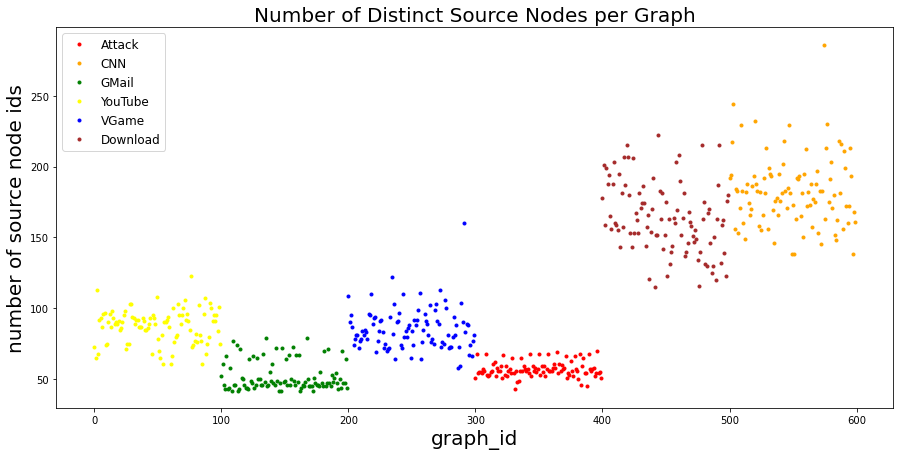

In [11]:
plt.figure(figsize=(15, 7))

graph_types = list(graph_type_color_map.keys())
colors = list(graph_type_color_map.values())
for idx in range(6):
    temp_df = df_source_destination_count[df_source_destination_count.graph_type == graph_types[idx]]
    plt.plot(temp_df.graph_id, temp_df.number_source_id, '.', label =graph_types[idx], color=colors[idx])
    plt.xlabel('graph_id', fontsize=20)
    plt.ylabel('number of source node ids',  fontsize=20)
plt.legend(fontsize=12, loc = 2)
plt.title('Number of Distinct Source Nodes per Graph', fontsize=20)
plt.show()

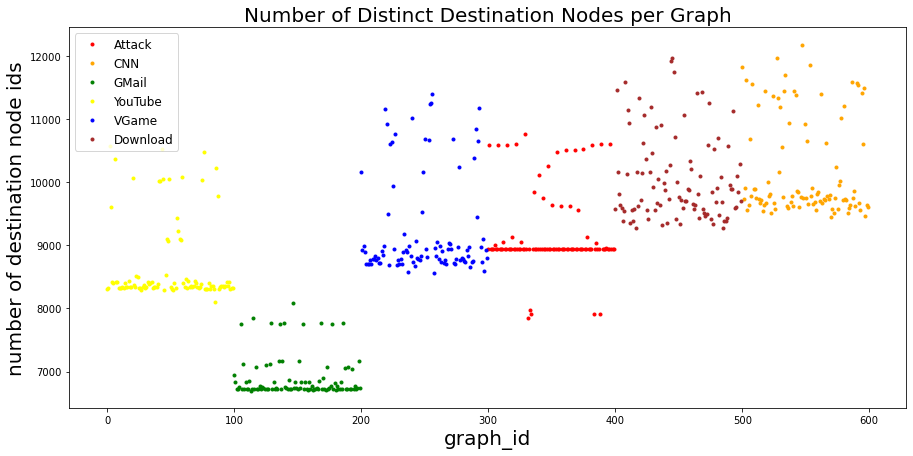

In [12]:
plt.figure(figsize=(15, 7))

graph_types = list(graph_type_color_map.keys())
colors = list(graph_type_color_map.values())
for idx in range(6):
    temp_df = df_source_destination_count[df_source_destination_count.graph_type == graph_types[idx]]
    plt.plot(temp_df.graph_id, temp_df.number_destination_id, '.', label =graph_types[idx], color=colors[idx])
    plt.xlabel('graph_id', fontsize=20)
    plt.ylabel('number of destination node ids',  fontsize=20)
plt.legend(fontsize=12, loc=2)
plt.title('Number of Distinct Destination Nodes per Graph', fontsize=20)
plt.show()

# Visualize SubGraphs

Each graph is too big to visualize. 

Visualize SubGraphs created from 100 rows of the input file. 

Even though each graph below is created from 100 rows, the number of nodes varies. The reason is because most of the time the same nodes are present in multiple rows. 
The thicknes of the edges is proportional to the number of connections between the two nodes.

The nodes are colored according to their types; the edges are not colored. 

## Node Color Legend

### <span style="color:red">&#9679;</span>  process   &emsp; <span style="color:orange">&#9679;</span>  thread  &emsp; <span style="color:green">&#9679;</span>  file  &emsp;
### <span style="color:yellow">&#9679;</span>  stdin  &emsp; <span style="color:blue">&#9679;</span>  stdout  &emsp; <span style="color:brown">&#9679;</span>  stderr
### <span style="color:black">&#9679;</span>  NA

# YouTube

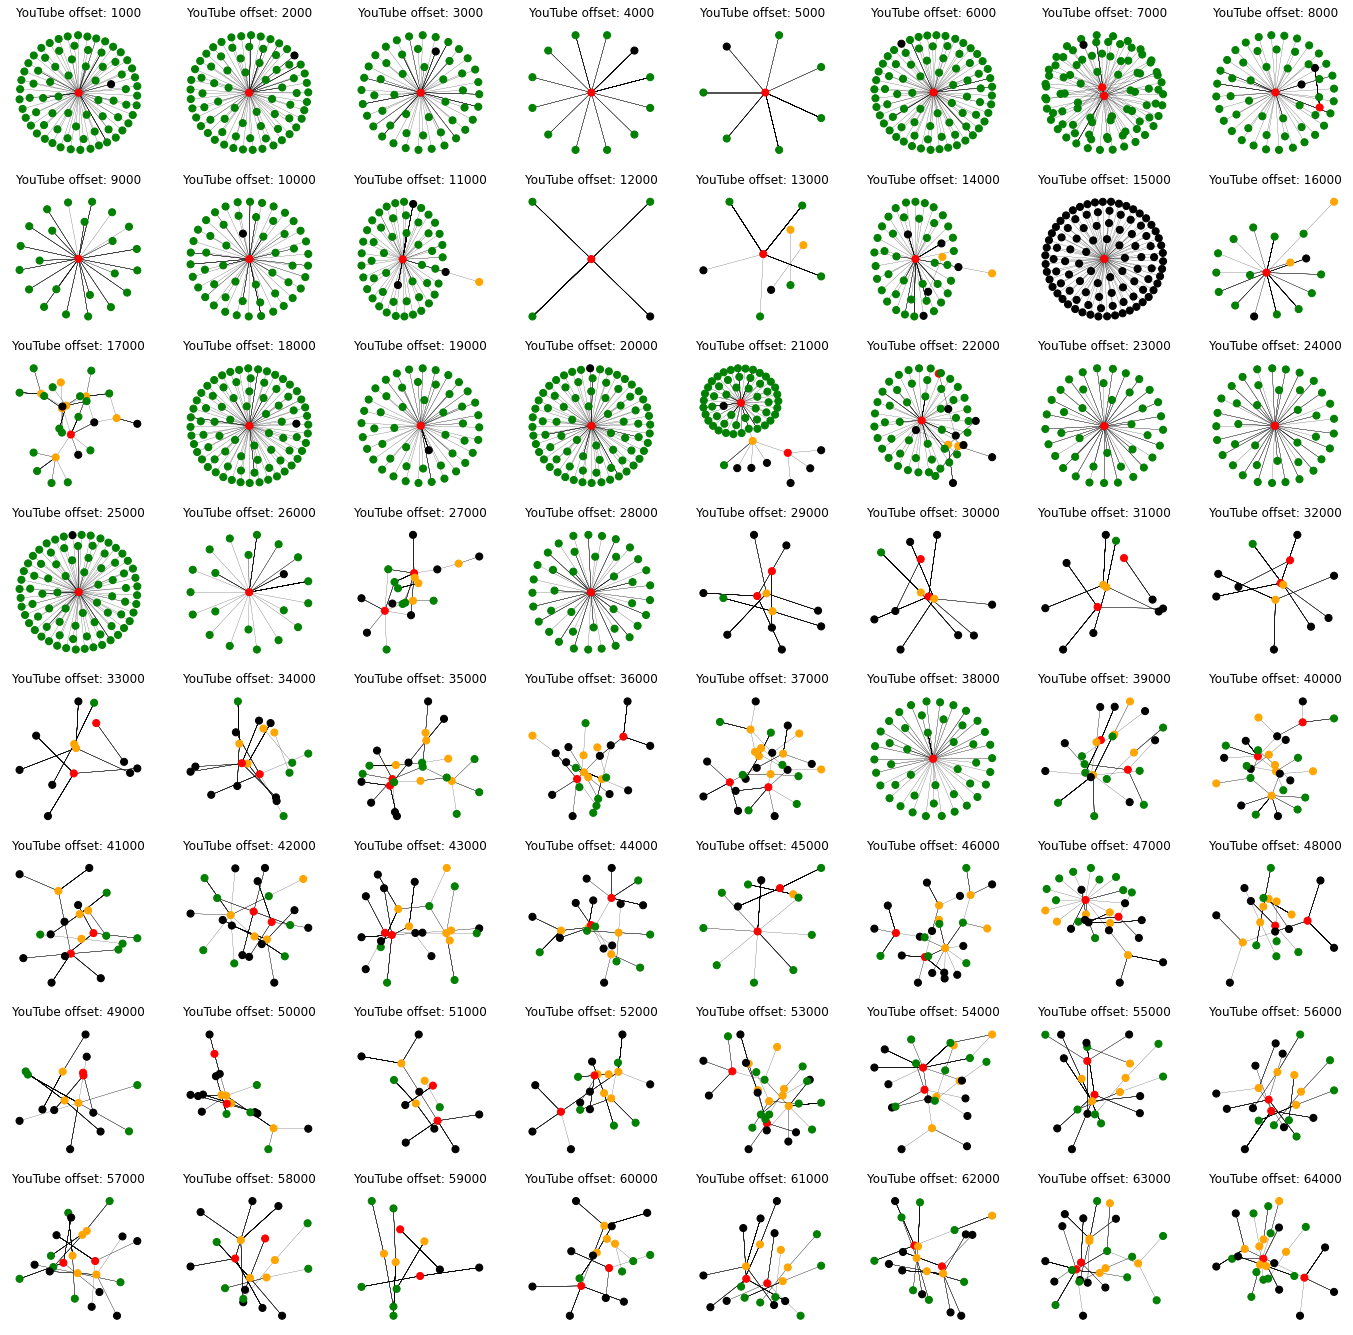

In [13]:
label = 'YouTube'
graph_id = 51
max_number_subgraphs = 64
sub_graph_size = 100
shift = 1000
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)

# GMail

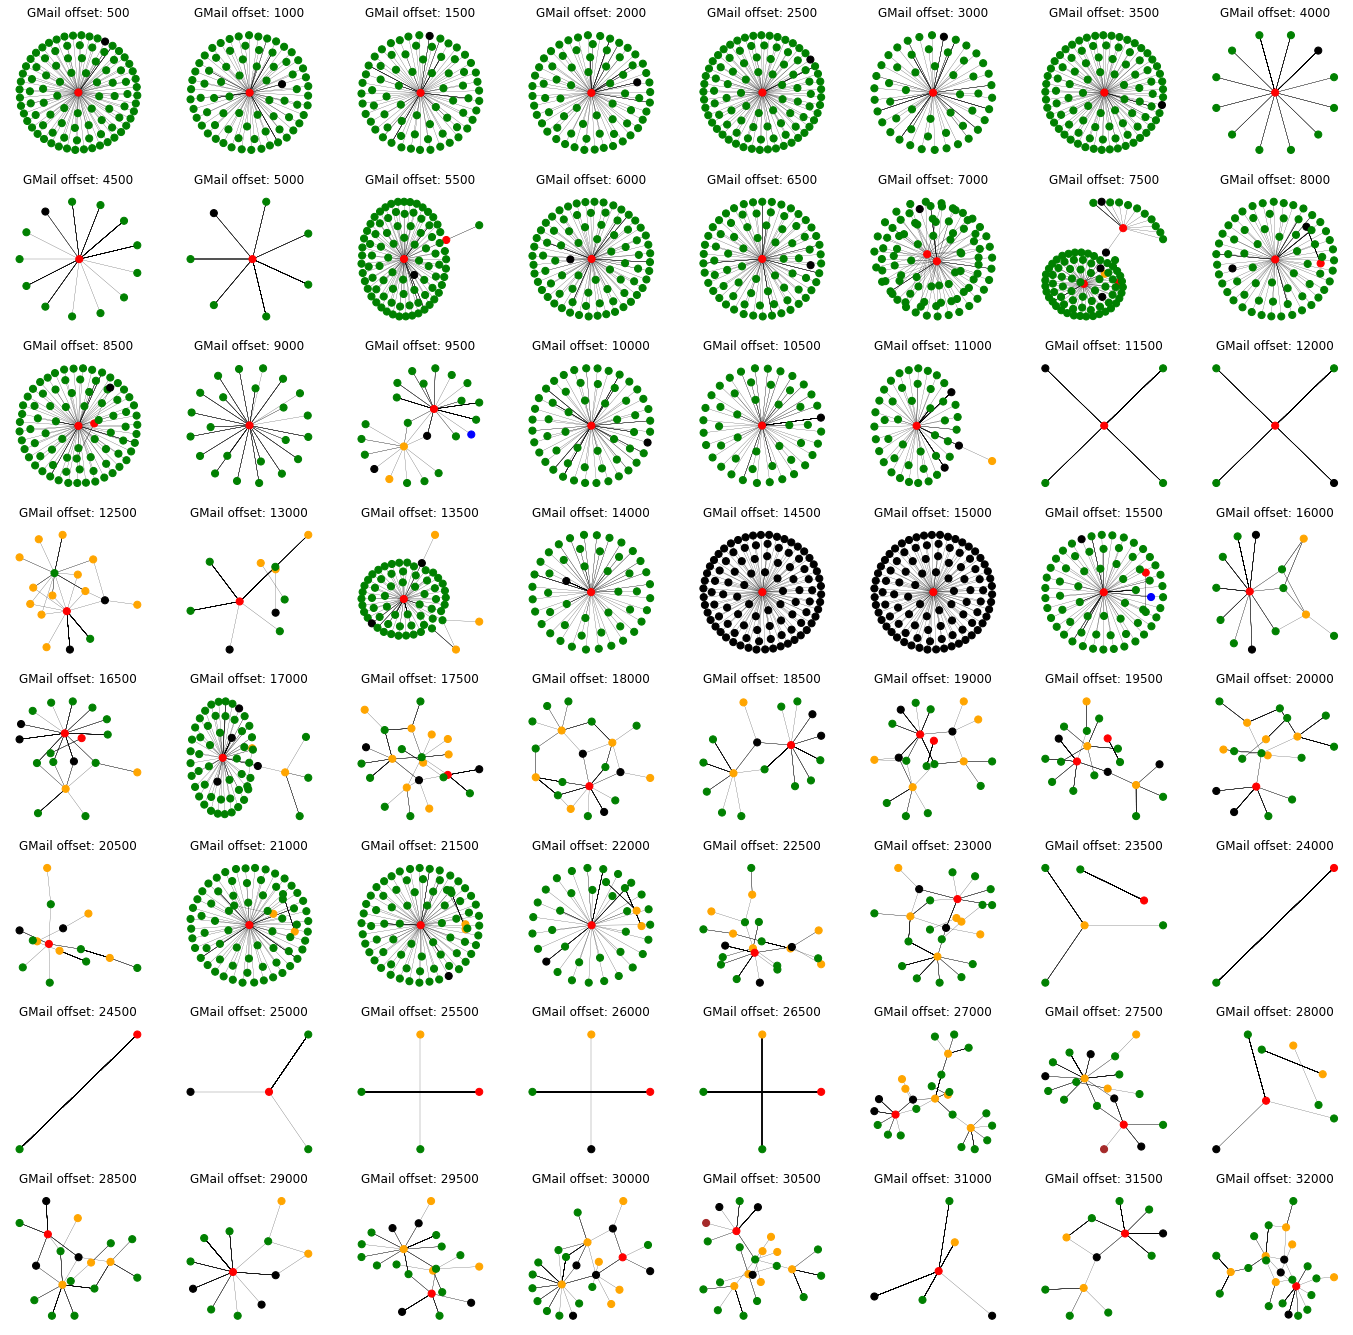

In [14]:
label = 'GMail'
graph_id = 151
max_number_subgraphs = 64
sub_graph_size = 100
shift = 500
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)

# VGame

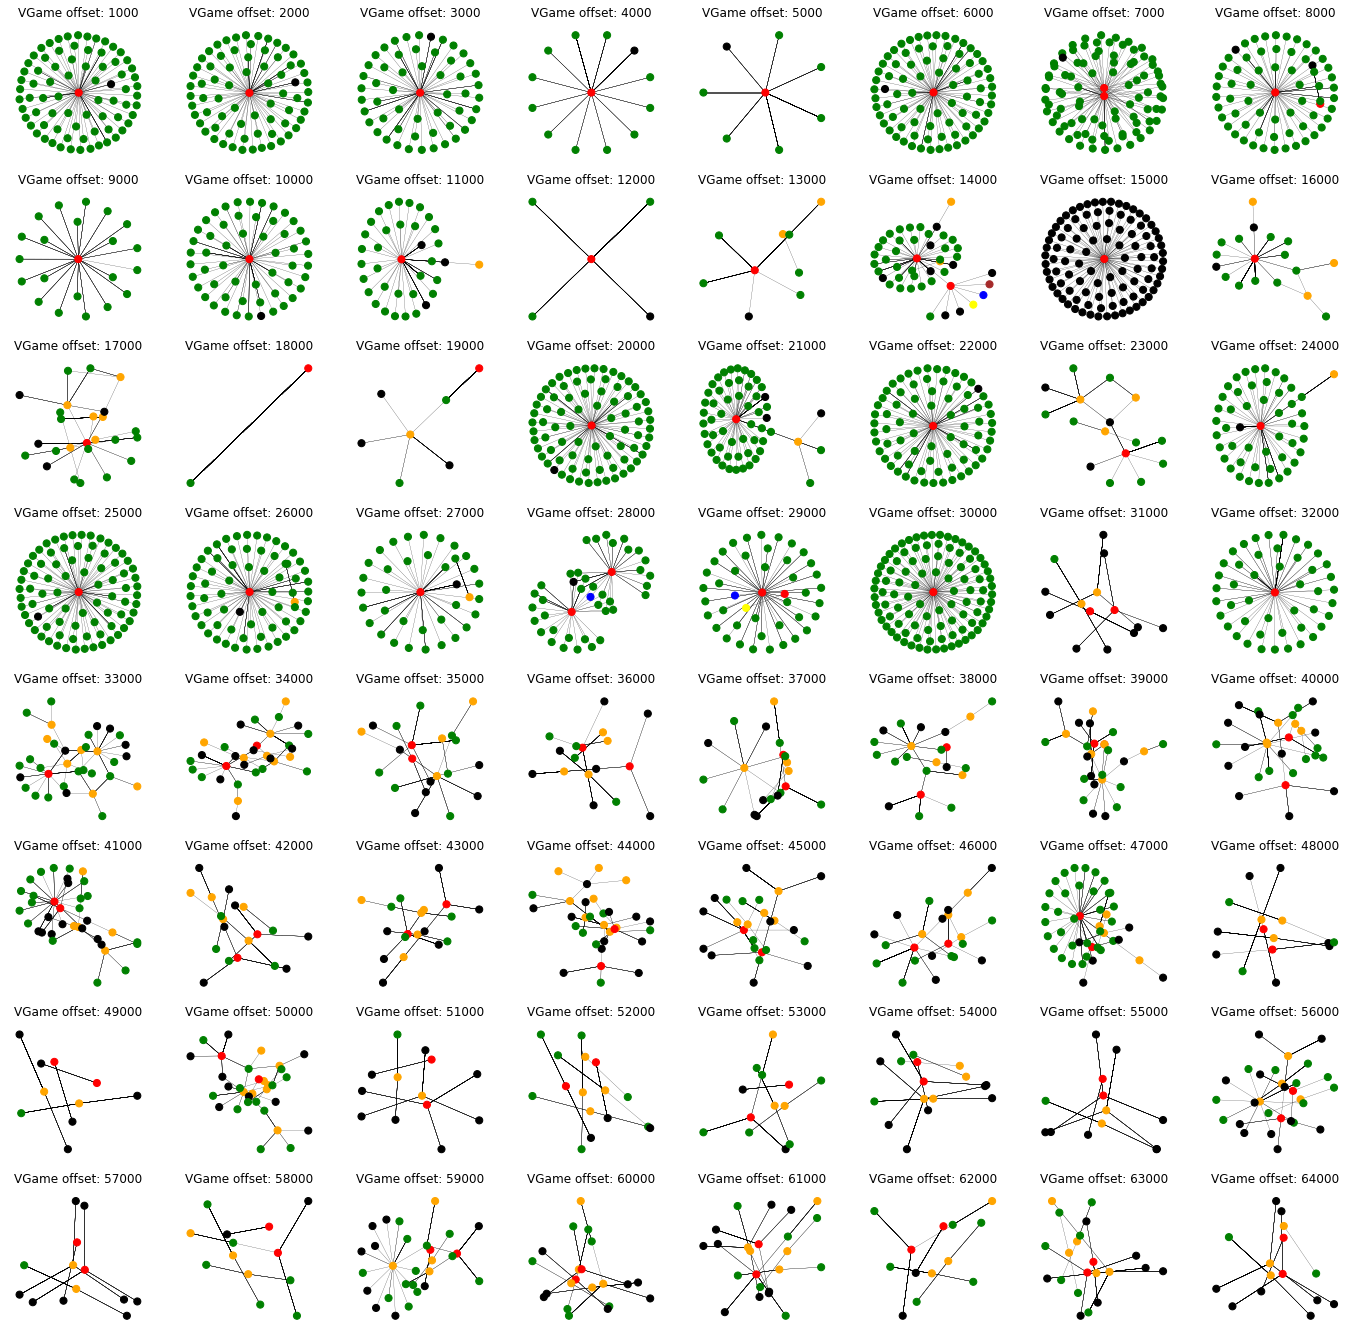

In [15]:
label = 'VGame'
graph_id = 251
max_number_subgraphs = 64
sub_graph_size = 100
shift = 1000
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)

# Drive-by-download attack

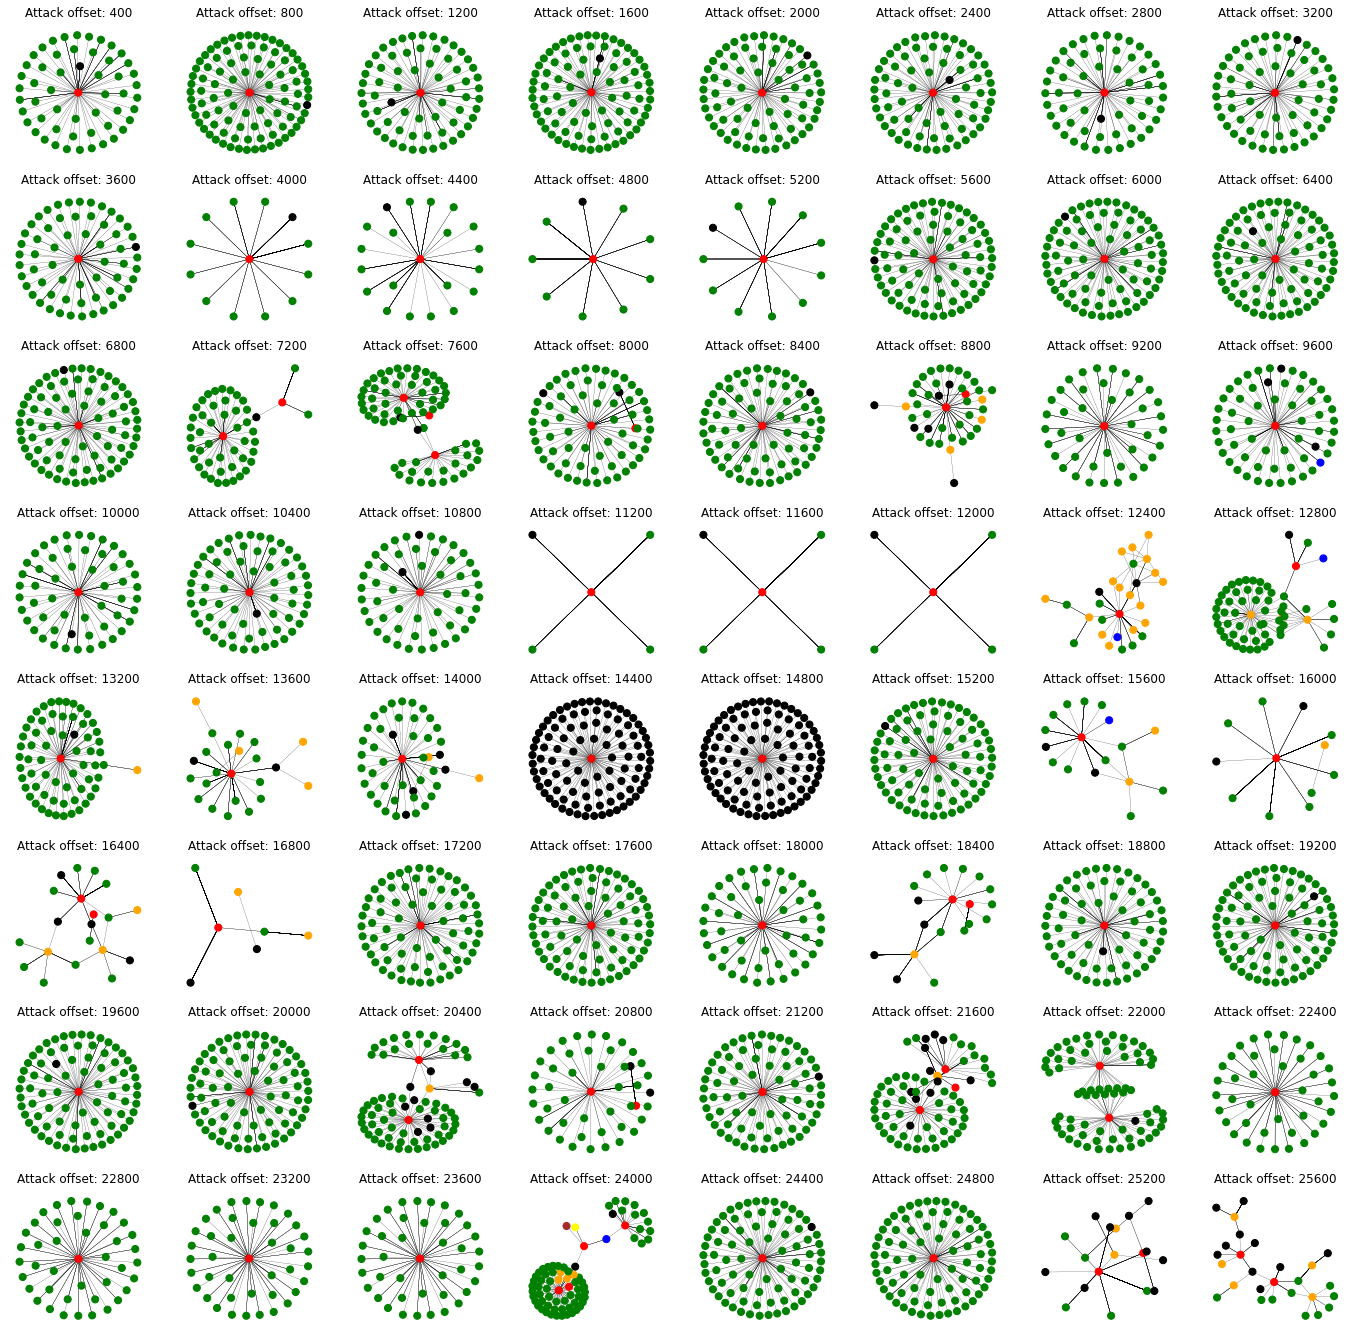

In [16]:
label = 'Attack'
graph_id = 301
max_number_subgraphs = 64
sub_graph_size = 100
shift = 400
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)

## Download

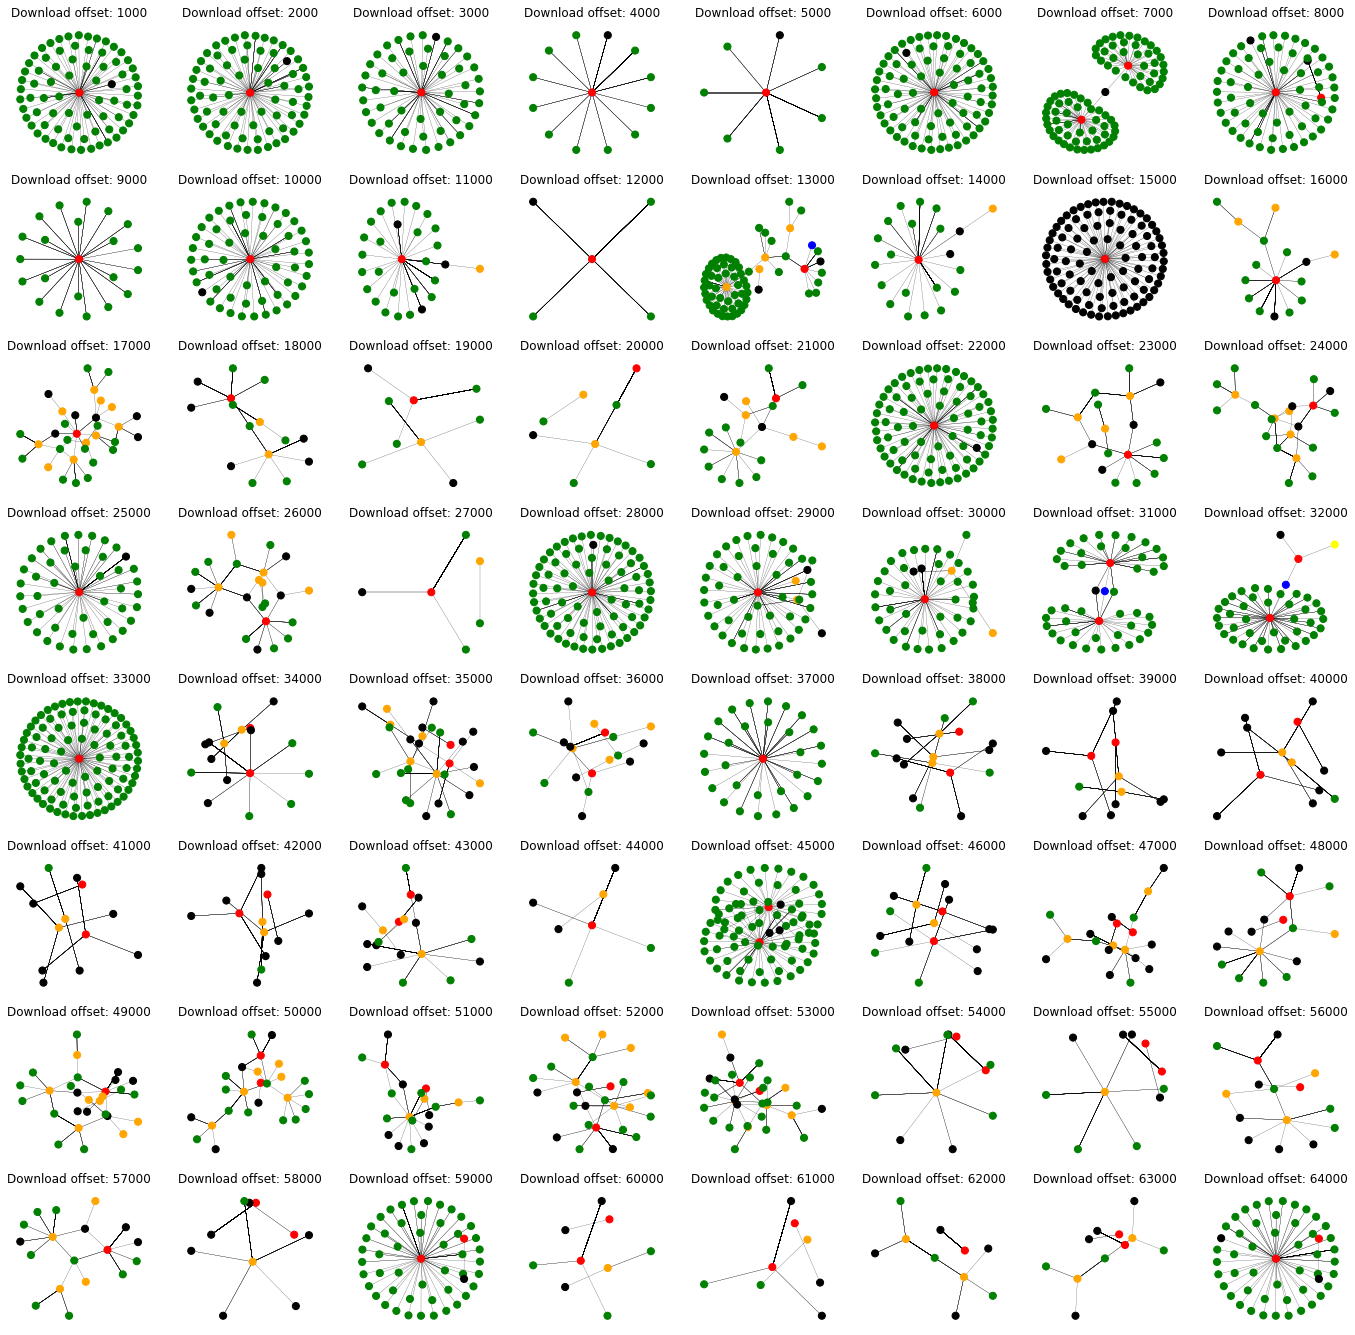

In [17]:
label = 'Download'
graph_id = 451
max_number_subgraphs = 64
sub_graph_size = 100
shift = 1000
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)

## CNN

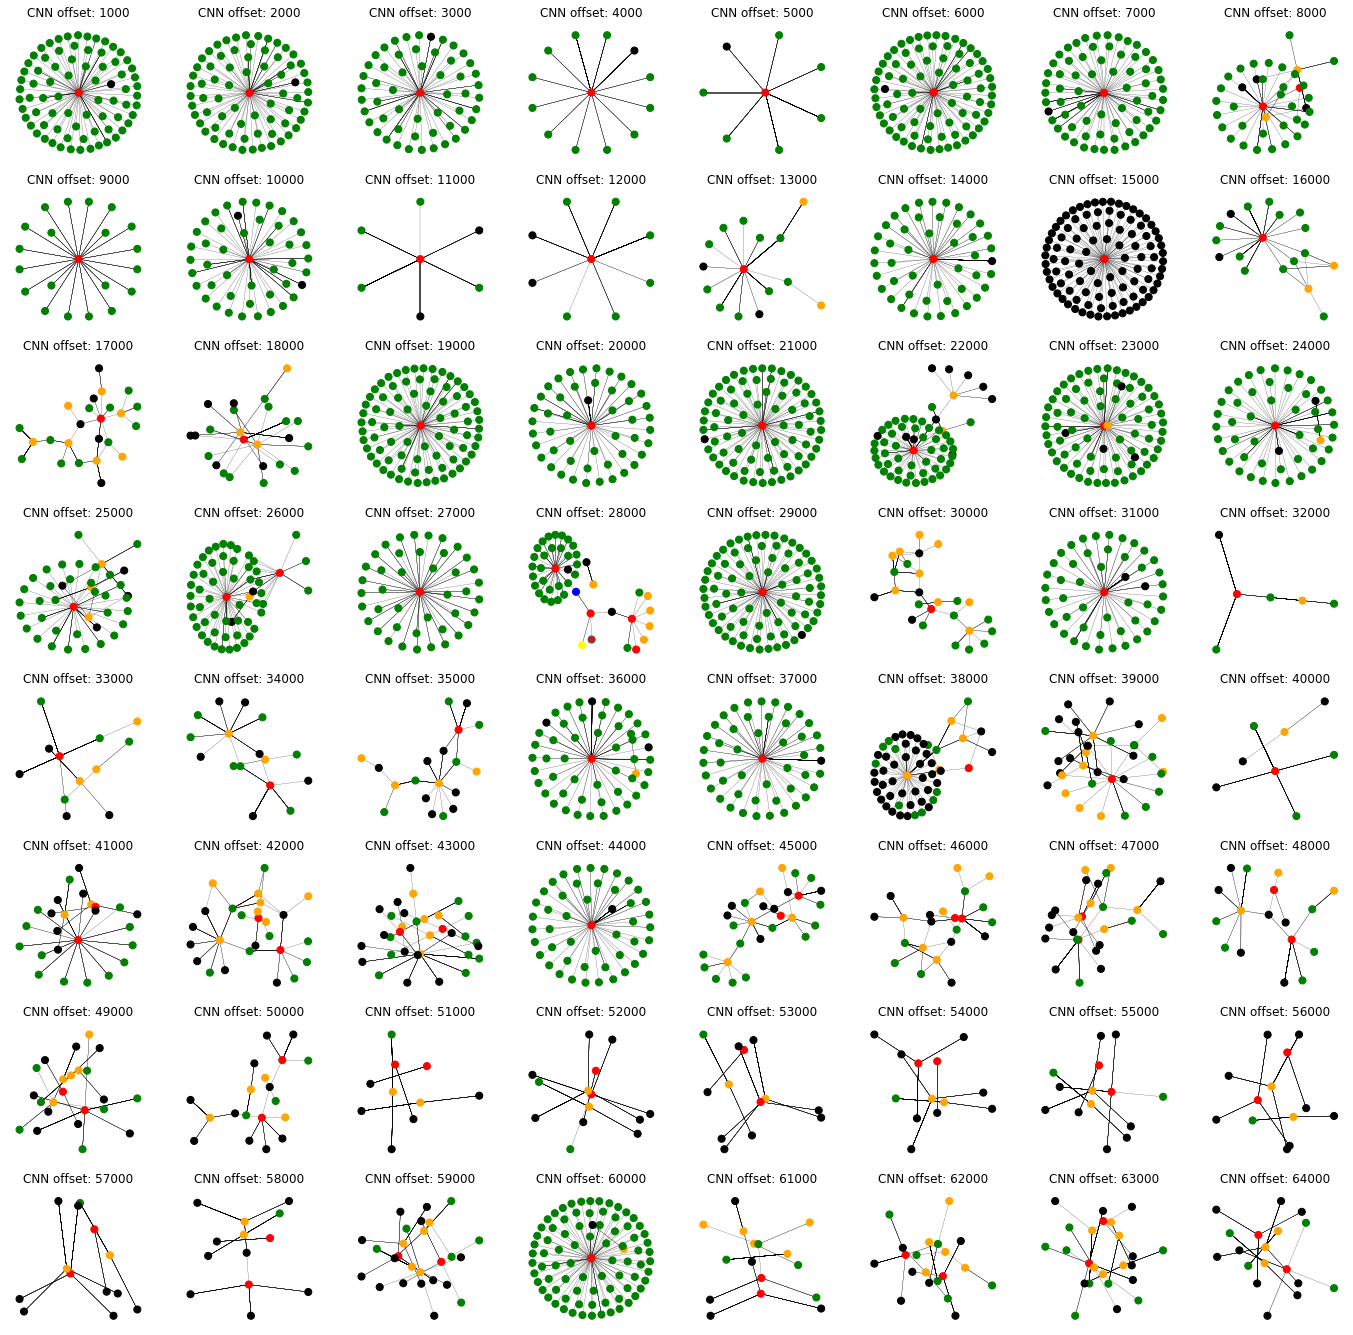

In [18]:
label = 'CNN'
graph_id = 551
max_number_subgraphs = 64
sub_graph_size = 100
shift = 1000
visualize_subgraphs(graph_id, sub_graph_size, shift, max_number_subgraphs, label, ncols = 8)